# Data Visualization with PCA

## The Challenges of High-dimensional Data

Once we decide to measure more than three features per input vector, it can become challenging to understand how a network is learning to solve such a problem since we can no longer generate a plot or visualization of the feature vector space to which the network is being exposed. One-, two-, or three-dimensional vectors are easy enough to plot, and we could even color the corresponding points based on their class assignments to see how groups of similar items are in similar parts of the vector space. If we can see straight boundaries (lines or planes) between the differently colored point clouds, then we would understand why a linear (i.e. single-layer) network might be capable of producing a reasonable solution to the problem at hand. Also, if we see regions where a single line/plane will not suffice for separating the different classes, then we might have reason to suspect that a linear network will fail to solve the problem, and probably attempt to use a multilayer network instead.

Given the advantages of visualizing such relationships, a common trick when exploring high-dimensional data sets is to **project** the high-dimensional data vectors onto a low-dimensional space (two or three dimensions) where we can see if such relationships exist. Such projection is _risky_ in the sense that we will be throwing information away to perform the projection (similar to how neural networks throw information away when performing regression or classification), and we may no longer see some important relationships in the low-dimensional projection of the data. However, it is sometimes possible that the projection **will** preserve relationships between the original data vectors that are important for making an accurate classification or regression while also enabling visualization.

In this assignment, we will explore a commonly-used **linear** projection known as Principal Component Analysis (PCA) to visualize some data sets and see how such projections might be useful for understanding why our single-layer networks were able to effectively learn the functions that these data sets represent. Since PCA is a linear method, it will be limited in its ability to produce useful _projections_ in a manner roughly analogous to how single-layer neural networks are limited in their ability to solve _linearly separable_ problems. Since we will be producing low-dimensional projections, relative to the original dimensionality of the vectors, this technique is also a form of **dimensionality reduction** in that the new two- or three- dimensional vectors that we produce will still share some of the relationships between one another that the higher-dimensional vectors possessed. This might even mean that we could use these new vectors as inputs for a neural network instead of the original, high-dimensional vectors. This could lead to a significant reduction in the number of neural units and connection weights in a network, and hence reduce its computation time. Also, some of the original features (or combinations of features) may just not be very useful for the problem at hand, and removing them would allow the network to focus on only the more relevant features in the data. In some cases (albeit rarely with PCA), this can even lead to superior performance of the trained neural network overall. While we will focus on two-dimensional projections in this assignment, PCA can be used to reduce the dimensionality of a given set of input vectors to any chosen number less than or equal to the original dimensionality. The smaller the dimensionality of the projection: the more information is being projected away. Thus, two-dimensional projections are often too low to be of any real use on many large data sets. However, some data sets might be reduced from millions of features to thousands, or thousands to hundreds, while still preserving the vast majority of the information that they encode. Such large reductions can make certain problems far more tractable to learn than they would otherwise be.

## Gathering the Iris data set

Let's start out by grabbing some data that we are already a little familiar with, and see if we can use PCA to better understand why a linear network can learn to solve this function effectively.

Let's start by importing some tools for the job...

In [1]:
# For reading data sets from the web.
import pandas

# For lots of great things.
import numpy as np

# To make our plots.
import matplotlib.pyplot as plt
%matplotlib inline

# Because sympy and LaTeX make
# everything look wonderful!
import sympy as sp
sp.init_printing(use_latex=True)
from IPython.display import display

# We will use this to check our implementation...
from sklearn.decomposition import PCA

# We will grab another data set using Keras
# after we finish up with Iris...
import tensorflow.keras as keras

Now let's grab the Iris data set and start projecting!

In [2]:
iris_data = np.array(
        pandas.read_table(
            "https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/iris-data.txt",
            delim_whitespace=True,
            header=None))

In [3]:
# Remember the data is composed of feature
# vectors AND class labels...
X = iris_data[:,0:4] # 0,1,2,3
Y = iris_data[:,4]   # 4

# Pretty-print with display()!
display(X.shape)
display(Y.shape)
display(sp.Matrix(np.unique(Y)).T)

The Iris data set consists of 150 four-dimensional feature vectors, each one assigned to one of three class labels (0,1,2) corresponding to an iris species.

We could potentially use **four** dimensions to plot and understand this data. Namely, we could make 3D plots using the first three dimensions, and sort the points along the fourth dimension so that we could play them in-sequence like a movie. However, that can still be tricky to visualize since we may miss some relationships between frames in our "movie" if they are far apart in time. Potentially more useful would be to plot the first three dimensions in one plot, then the last three dimensions in another, where the two plots now share the middle two dimensions. Still, if relationships between the first and fourth dimensions were the most important, we might not see them very clearly using this presentation.

Let's see if a PCA projection down to just two dimensions would be more effective.

To do this we will be using some linear algebra that we have already seen before, but we need to process the data just a little before we can use those tools.

First, we will _mean-center_ the values of _each_ feature in the data. That is, we will find the _mean_ value of the first feature across all examples in the data set, and then subtract the mean value from this feature for all examples. We will perform the same operation for all four features as well, so that each feature will have its mean value effectively set to zero. You can think of this as moving the entire set of data vectors so that the average of the data vectors now lies at the value zero in all four dimensions. In other words, it's a _translation_ operation on the original data. The relative distances between all of the points is maintained, so all of the relationships between the data vectors important for classification is maintained as well.

We will use a custom function for this, that we apply to each of the columns using the `apply_along_axis()` function:

In [4]:
# Mean center a vector
def mean_center(x):
    return x - np.mean(x)

# Call this function for each column in the data (move along axis 0 or the rows)
Xcentered = np.apply_along_axis(mean_center,0,X)

Now that we have a mean-centered data matrix, we will use singular value decomposition to extract the left-singular vectors and singular-values of this matrix. 

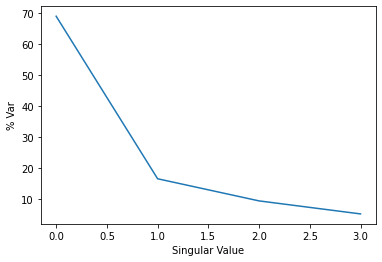

In [5]:
U,S,V = np.linalg.svd(Xcentered,full_matrices=True)

# Percent variance accounted for
plt.plot(100.0*S/np.sum(S))
plt.ylabel('% Var')
plt.xlabel('Singular Value')
plt.show()

Each of the singular values indicate some amount of variance present in the original data set that is captured by the corresponding left-singular vector (column of U). They are sorted in order from largest to smallest when returned by the `svd()` function so that you can see that the largest amount of variance is captured by the first left-singular vector, the second most variance by the second singular-vector, and so on. Often, the sum of the singular values is calculated to obtain the _total_ variance in the data, and then used to normalize the variance to obtain the percentage of variance captured by each left-singular vector. Given the data above, it is clear that the first two vectors alone will account for over 85% of the total variance in the data, and should form a reasonable projection for the data set.

In [6]:
# Variance accounted for in the first two principal components
100.0*(S[0]+S[1])/np.sum(S)

The singular-values (S) are mapped into a rectangular, diagonal matrix which is then multiplied by the left-singular vectors (U). The vectors in U are all unit length, so this operation effectively scales the length of the first 4 vectors by each of the corresponding singular values. In the end, these operations will produce a rotated version of our original data set where the major orthogonal directions capturing the largest variance in the data lie along the principal axes (x and y for a 2D plot). Each of these so-called principal components is a linear combination of our original feature vectors, and allows us to produce a projection onto a smaller set of these components by simply throwing away vectors associated with small singular values. Thus, while we obtain all 4 of the principal components for the iris data set, we will throw away the last two as they capture less than 15% of the variance in the data.

In [7]:
# Scale the singular vectors, resulting in a rotated form of our mean-centered data
D = np.zeros([X.shape[0],X.shape[1]])
np.fill_diagonal(D,S)
Xrotated = np.dot(U,D)

# Extract just the first two principal components!
PCs = Xrotated[:,0:2]
PCs.shape

Now that we have projected our data set into a low-dimensional space where we can better visualize it, let's make a plot to see how it looks. We will be careful to color the points by the associated class label.

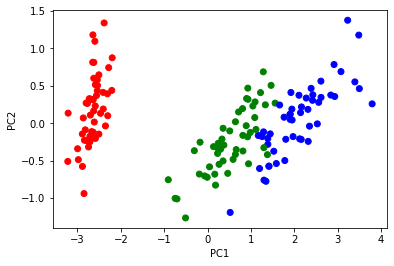

In [8]:
# The x and y values come from the two
# Principal Components and the colors for
# each point are selected based on the
# corresponding iris species for each point... 
plt.scatter(PCs[:,0],PCs[:,1],
            color=[['red','green','blue'][i] for i in Y.astype(int)])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

You can see in the above plot that the data forms three fairly distinct groups of points. The red group on the left is easily linearly separable from the other two groups. Even the green and blue groups are fairly distinct. While you can almost draw a straight line between them, it appears that a few data points from each of these groups would lie on the opposite side, and not allow for perfect classification with a linear network. Nevertheless, we can now see why a linear network might work well on this data, and (perhaps more importantly) that an additional feature measurement may be needed to completely separate the green and blue species.

We can perform the same analysis (just like we performed PCA above from scratch with numpy) by using the SciKitLearn library:

In [9]:
pca = PCA(2)
PCs = pca.fit_transform(X)[:,0:2]

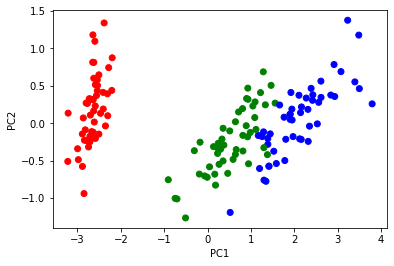

In [10]:
plt.scatter(PCs[:,0],PCs[:,1],
            color=[['red','green','blue'][i] for i in Y.astype(int)])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

The result is the same here, but you will sometimes notice that this data has been "flipped" or "mirrored" along the origin of one (or both) of the principal components. This commonly occurs since there is an equally valid rotation of the data 180 degrees along any axis that still preserves all of the variance and internal relationships between the data points. Either way, the same amount of variance is accounted for on each component, and decision boundaries can still be explored.

Let's perform a similar analysis with a much larger data set.

## Exploring MNIST with PCA

In [11]:
# Load the MNIST data set using Keras
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Subsample (there's a lot of data here!)
X = x_train[range(0,x_train.shape[0],10),:,:]
Y = y_train[range(0,y_train.shape[0],10)]

display(X.shape)
display(Y.shape)

We will only look at the training data for this data set for now (the test data is of the same kind so will not be needed for our purposes in this assignment). The training set consists of 60,000 images each 28x28 pixels in size. However, we have selected just 6000 of those images for this example to make the analysis more tractable (60,000 would take a long time and lots of memory to compute the PCs). Each pixel is represented by an integer intensity value between 0 and 255. For the sake of examining what these images look like, let's scale those intensities to be floating point values in the range [0,1]: 

In [12]:
X = X.astype('float32') / 255.0

Once normalized, the images can be easily plotted as a kind of "heatmap" where black pixels are represented by low intensities and white pixels by high intensities. The `imshow()` function will map high intensities to a dark colors (blue) and low intensities to light colors (yellow). Intermediate values are colored green with more or less blue/yellow depending on which intensity they favor more.

Let's take a look at the first five images in our subset of the MNIST data...

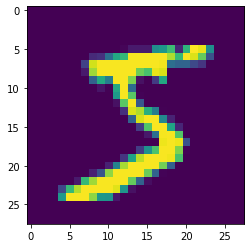

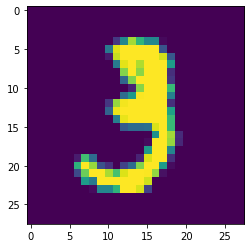

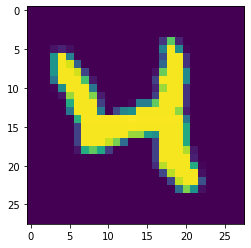

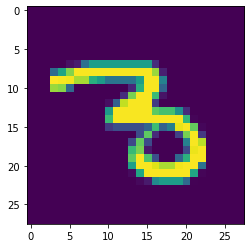

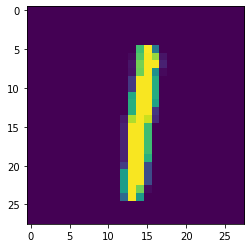

In [13]:
# Plot some of the images
for i in range(5):
    plt.figure()
    plt.imshow(X[i,:,:])
plt.show()

In [14]:
# What are their corresponding class labels?
display(sp.Matrix(Y[0:5]))

You can see that each of these images corresponds to a hand-written digit, each labeled with the appropriate number in the category labels, Y.

We will now **flatten** these images so that we can perform principal component analysis, so that each pixel is treated as a single measurement. The numpy function `reshape()` allows us to do this by providing a new shape for the data that has the same _total_ number of entries. Here we convert earh 28x28 matrix (image) into a 784 element vector (since 28x28=784). PCA can still detect relationships between the pixel values even when they are not arranged in a matrix form, so we treat each image as a vector.

In [15]:
X = X.reshape(X.shape[0],X.shape[1]*X.shape[2])
X.shape

Each image has now been encoded as a feature vector in a 784-dimensional space. Even though the pixel intensities make sense to us when visualized as a 2D image, newly initialized neural networks only experience the vector space for the first time, and have to learn such relationships from scratch. However, let's see if PCA can provide some insight on the difficulty of this task.

We will apply the same approach as before:
1. mean-centering the features
2. calculating the SVD
3. examining the singular values
4. scaling the left-singular vectors
5. plotting the two-dimensional projection

NOTE: It may take a minute or so to compute the SVD for a data set of this size, so be patient on the steps below.

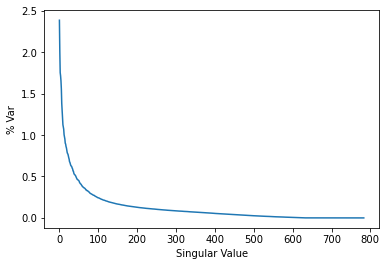

In [16]:
# Mean-centering
Xcentered = np.apply_along_axis(mean_center,0,X)

# SVD
U,S,V = np.linalg.svd(Xcentered,full_matrices=True)

# Percent variance accounted for
plt.plot(100.0*S/np.sum(S))
plt.ylabel('% Var')
plt.xlabel('Singular Value')
plt.show()

In [17]:
# Variance accounted for in the first two principal components
100.0*(S[0]+S[1])/np.sum(S)

You can see that the variance accounted for dips sharply (which is good, because having a few PCs which capture a lot of variance is a useful thing). However, the variance captured by the first __two__ components together is _less than 5% of the total variance_ in the data set, so PCA might __not__ be so useful for visualization.

However, let's take a quick look at one more thing before moving on:

In [18]:
# Variance accounted for in the first two principal components
display(100.0*(np.sum(S[0:340]))/np.sum(S))

# Reduction?
display(100*340/len(S))

Notice that 90% of the **total** variance in the data can be captured using 340 principal components. 340 is only just over 43% of the original dimensionality, so 90% of the data set can be effectively represented using a space less than half of the original in size. Thus, PCA can also be thought of as a lossy linear data compression technique as well. While we can't visualize a 340-dimensional space, a much smaller network would be required to process this data, possibly without sacrificing generalization accuracy (but that's for a later time). Let's just take a look at the first two principal components for now:

In [19]:
D = np.zeros([X.shape[0],X.shape[1]])
np.fill_diagonal(D,S)
Xrotated = np.dot(U,D)

# First two principal components!
PCs = Xrotated[:,0:2]
PCs.shape

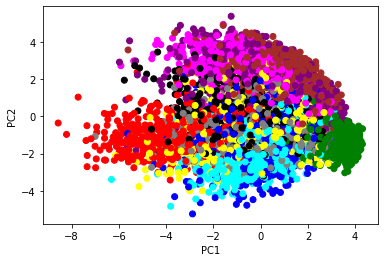

In [20]:
# Need a lot of colors for this one!
plt.scatter(PCs[:,0],PCs[:,1],
            color=[['red','green','blue',
                    'cyan','magenta','yellow',
                    'black','brown','grey',
                    'purple'][i] for i in Y.astype(int)])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Note that the clutter of 6000 points is pretty bad in this space, and reducing the sampling may help in some ways. Let's try that now:

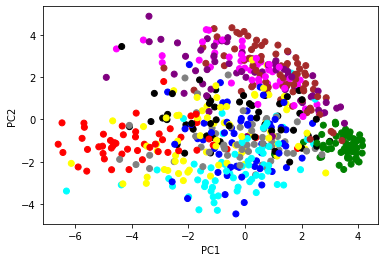

In [21]:
plt.scatter(PCs[range(0,6000,10),0],PCs[range(0,6000,10),1],
            color=[['red','green','blue',
                    'cyan','magenta','yellow',
                    'black','brown','grey',
                    'purple'][i] for i in Y[range(0,6000,10)].astype(int)])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Even with the subsampling, some interesting divisions between classes can be found, but others are not so clear. For example, the red points now correspond to images of zeros and green dots now correspond to images of ones, and these seem to lie on opposite ends of the first principal component. Also, the brown sevens seem very distinct from the cyan threes. However, others are more cluttered, like the purple nines, brown sevens, and magenta fours. However, this makes some sense because these numbers share some common featural similarities.

Because PCA is a **linear** technique, it is somewhat limited in its ability to capture some of the **non-linear** relationships between the data vectors. Also, two dimensions, while useful for visualization, is still often too low to capture all of the relevant relationships that allow for categorization. The 2D representation can be thought of as capturing the **lower-bound on the distances between the data vectors** since *adding more dimensions may cause points to move farther apart, but they could never cause them to move closer together*.

Even with its drawbacks, PCA is a useful technique for quickly creating projections of high-dimensional data onto lower-dimensional spaces for exploratory analysis and lossy compression. There is even a neural network architecture that we will look at briefly later in the semester which allows a single-layer network to learn to perform PCA on a set of data by using a specific learning rule (Oja's Rule). However, because we can solve linear problems like PCA in closed form just like we did above, it is atypical to utilize Oja's Rule since it requires training several many epochs and is therefore slower than closed-form solutions.